In [8]:
import os
import math
import ta
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Hàm lấy dữ liệu từ CoinGecko

In [10]:
def get_historical_data(coin_id, vs_currency, days, n_roc):
    url = f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart'
    params = {
        'vs_currency': vs_currency,
        'days': days
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    
    # Tính toán ROC
    df = calculate_roc(df, 'price', n_roc)
    
    return df

### Hàm xây dựng và dự đoán giá trị với mô hình LSTM

In [11]:
def predict_and_save(coin_id, vs_currency, days, n_roc, file_path):
    # Kiểm tra và tạo thư mục nếu cần
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    df = get_historical_data(coin_id, vs_currency, days, n_roc)
    df.dropna(inplace=True)  # Bỏ các giá trị NaN do tính toán ROC
    data = df.filter(['price', 'ROC'])
    dataset = data.values
    training_data_len = math.ceil(len(dataset) * .8)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    train_data = scaled_data[0:training_data_len, :]
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=32, epochs=10)

    test_data = scaled_data[training_data_len - 60:, :]
    x_test = []
    y_test = dataset[training_data_len:, 0]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 1))), axis=1))[:, 0]

    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16, 8))
    plt.title(f'Model {coin_id.upper()}-{vs_currency.upper()}')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['price'], label='Train')
    plt.plot(valid['price'], label='Val')
    plt.plot(valid['Predictions'], label='Predictions')
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

    valid['Date'] = valid.index
    results = valid[['Date', 'price', 'Predictions']]
    results.to_csv(file_path, index=False)

    rmse = np.sqrt(mean_squared_error(valid['price'], valid['Predictions']))
    mae = mean_absolute_error(valid['price'], valid['Predictions'])
    mape = np.mean(np.abs((valid['price'] - valid['Predictions']) / valid['price'])) * 100

    print(f'{coin_id.upper()}-{vs_currency.upper()} RMSE: {rmse}')
    print(f'{coin_id.upper()}-{vs_currency.upper()} MAE: {mae}')
    print(f'{coin_id.upper()}-{vs_currency.upper()} MAPE: {mape}%')

### Dự đoán cho các cặp tiền

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.2161
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0377
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0154
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0094
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0088
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0081
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0094
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0092
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0080
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0057
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5332\3317960841.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


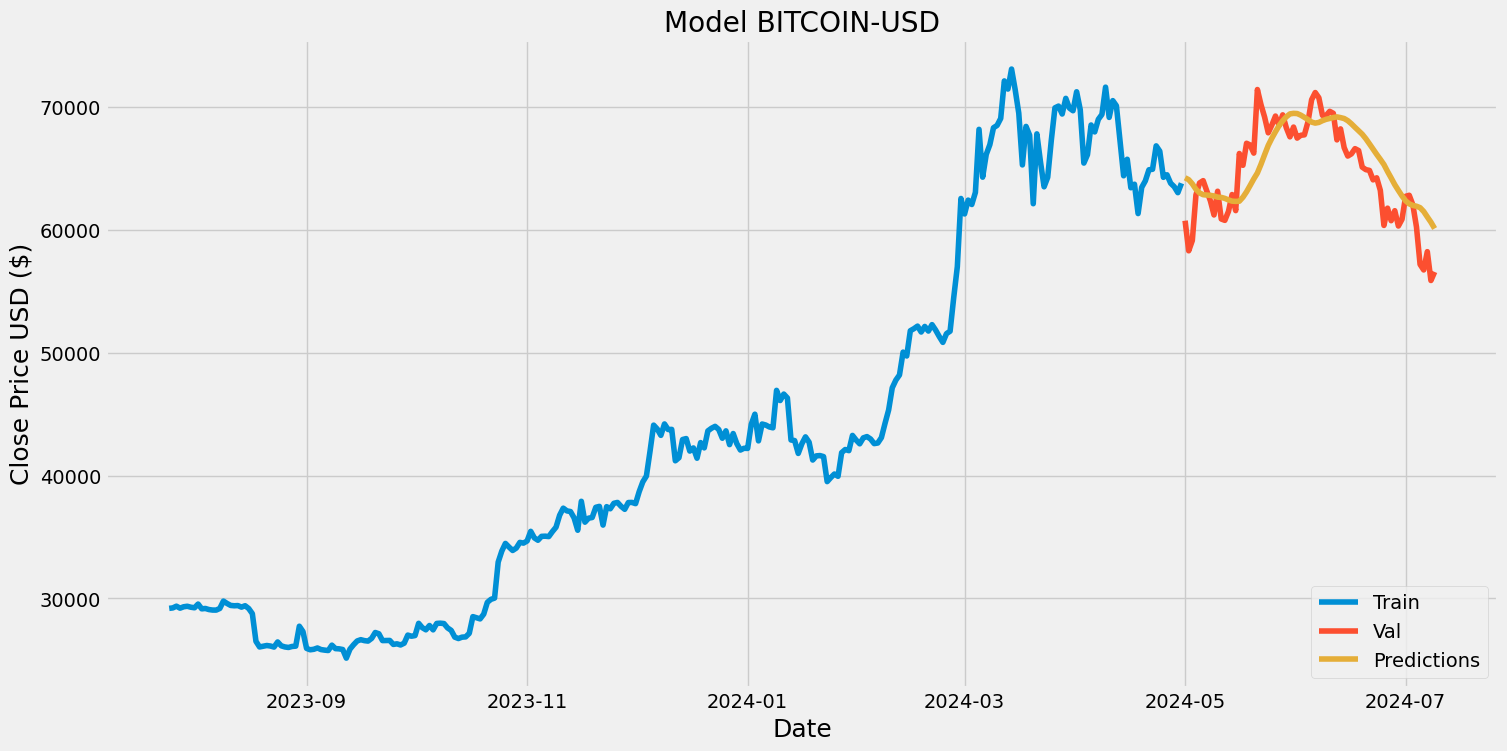

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5332\3317960841.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = valid.index


BITCOIN-USD RMSE: 2567.4912097263723
BITCOIN-USD MAE: 2088.0992202233624
BITCOIN-USD MAPE: 3.2867829665319412%


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 0.1514
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0360
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0239
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0113
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0105
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0087
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0085
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0058
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0064
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0063
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5332\3317960841.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


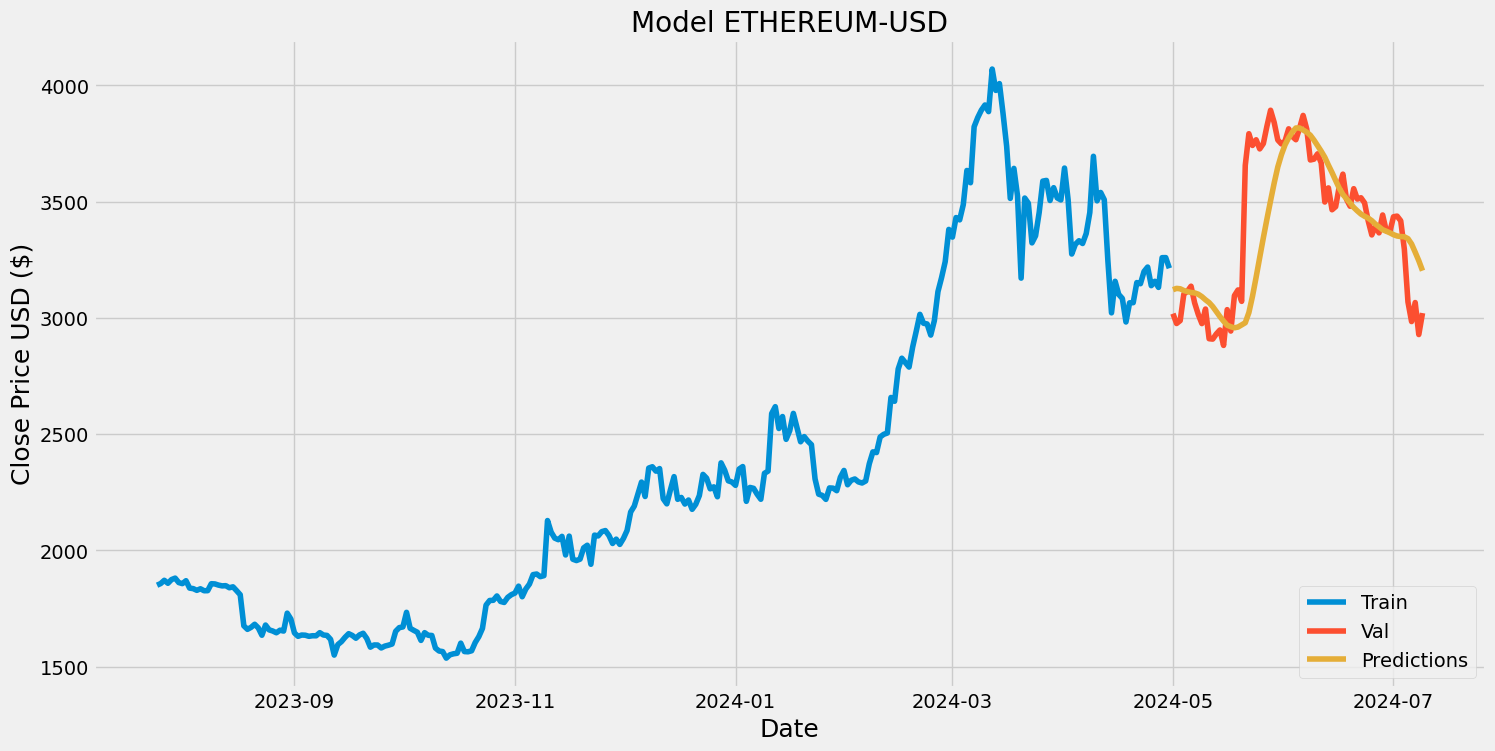

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5332\3317960841.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = valid.index


ETHEREUM-USD RMSE: 218.36171489866342
ETHEREUM-USD MAE: 138.84471196788175
ETHEREUM-USD MAPE: 4.031119625007321%
Epoch 1/10


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.1127
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0358
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0248
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0201
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0131
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0154
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0101
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0109
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0098
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0078
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001CEED3A3240> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tenso

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5332\3317960841.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


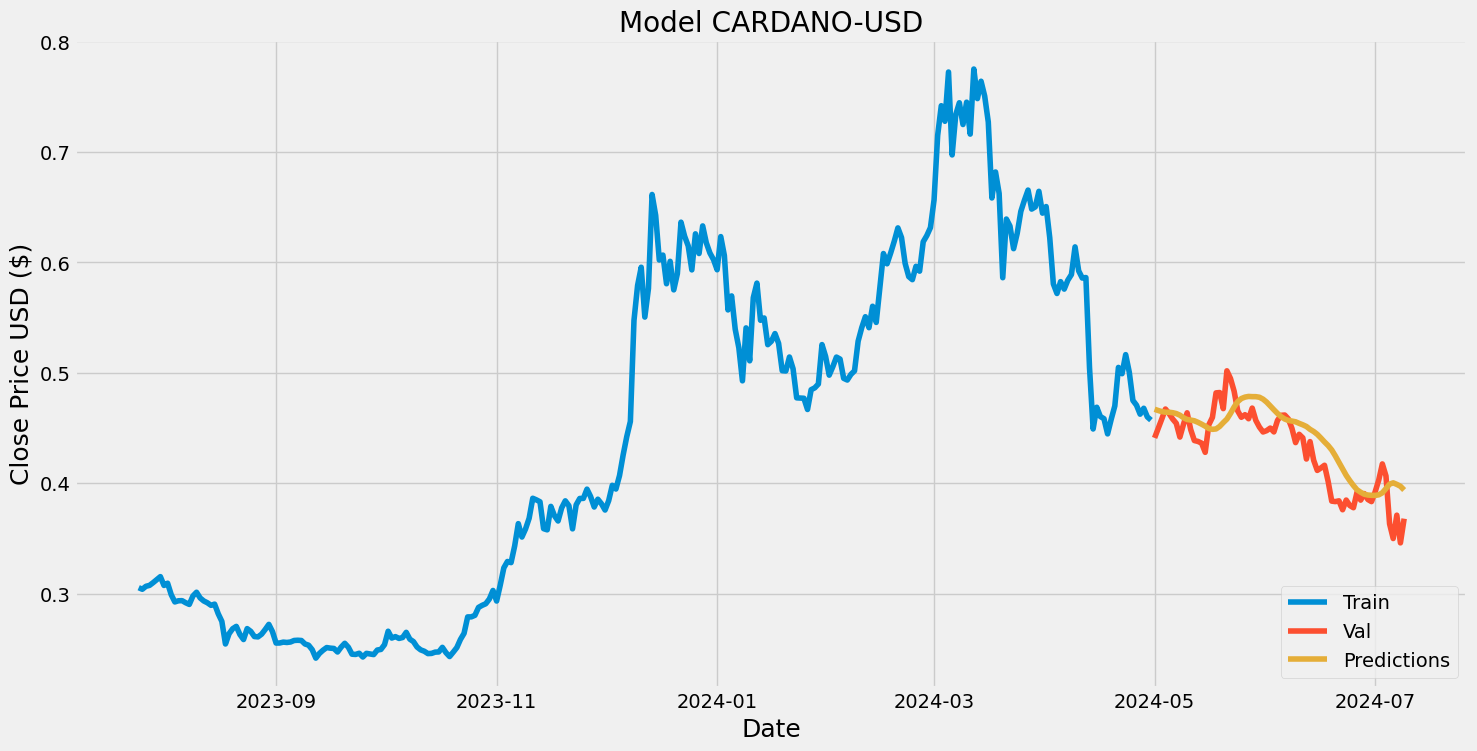

CARDANO-USD RMSE: 0.022594484576384535
CARDANO-USD MAE: 0.01870272908869455
CARDANO-USD MAPE: 4.483303699524141%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5332\3317960841.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = valid.index


In [12]:
# Dự đoán và lưu kết quả cho BTC-USD
predict_and_save('bitcoin', 'usd', '365', 14, '../output/LSTM/BTC-USD.csv')

# Dự đoán và lưu kết quả cho ETH-USD
predict_and_save('ethereum', 'usd', '365', 14, '../output/LSTM/ETH-USD.csv')

# Dự đoán và lưu kết quả cho ADA-USD
predict_and_save('cardano', 'usd', '365', 14, '../output/LSTM/ADA-USD.csv')
